<a href="https://colab.research.google.com/github/paulxdillon/Chem-Eng/blob/master/ResidueCurveMaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Calculation of azeotropes.

In [48]:
!pip install pyomo
import numpy as np
from scipy.optimize import curve_fit
import pylab
from scipy.optimize import fsolve
from scipy.integrate import odeint
import scipy as sp
from scipy.integrate import ode
from pyomo.environ import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt1

In [0]:
Components = ['Water','2-MCH','Acetone']
Pairs = ['Water/2-MCH', 'Water/Acetone', '2-MCH/Acetone']

In [0]:
NRTLparams = {'Pairs':['Water/2-MCH','Water/Acetone','2-MCH/Acetone','IPA/Ethanol','IPA/Methanol','Ethanol/Methanol','Water/Ethanol', 'Water/Methanol', 'IPA/Water',],
              'aij': [5.06045,      0.0544,         -1.01139,            0,              0,              0,              0,              0,                 -1.3115],
              'aji': [-2.4211,      6.3981,         1.28690,             0,              0,              0,              0,              0,                 6.8284],
              'bij': [-34.9329,     419.972,       115.763,            -266.3770,      -407.2343,      6.4080,         670.444,        425.323,             426.398],
              'bji': [1213.92,      -1808.99,        -112.44,            347.2905,       603.0893,       -13.0821,        -55.1698,       -127.757,          -1483.5],
              'cij': [0.2966,       0.3,            0.2992,             0.3125,         0.3012,         0.3356,         0.3031,         0.3012,               0.3]}

In [0]:
pair12 = Components[0]+'/'+ Components[1] #'Water/2-MCH'
pair13 = Components[0]+'/'+ Components[2] #'Water/Acetone'
pair23 = Components[1]+'/'+ Components[2] #'2-MCH/Acetone'

In [52]:
print(pair12, pair13, pair23)

Water/2-MCH Water/Acetone 2-MCH/Acetone


In [0]:
ncomp = 3
tau = np.ndarray((ncomp, ncomp),float)
alpha = np.ndarray((ncomp, ncomp),float)

df = pd.DataFrame(NRTLparams)
df.set_index("Pairs", inplace=True)

df.loc[pair12]
df.loc[pair12].loc['aij']

P = 1.01325 # barA
T = 60      # deg C (preliminary value)
a12 = df.loc[pair12].loc['aij']
a21 = df.loc[pair12].loc['aji']

a13 = df.loc[pair13].loc['aij']
a31 = df.loc[pair13].loc['aji']

a23 = df.loc[pair23].loc['aij']
a32 = df.loc[pair23].loc['aji']

b12 = df.loc[pair12].loc['bij']
b21 = df.loc[pair12].loc['bji']

b13 = df.loc[pair13].loc['bij']
b31 = df.loc[pair13].loc['bji']

b23 = df.loc[pair23].loc['bij']
b32 = df.loc[pair23].loc['bji']

c12 = df.loc[pair12].loc['cij']
c21 = df.loc[pair12].loc['cij']
c13 = df.loc[pair13].loc['cij']
c31 = df.loc[pair13].loc['cij']
c23 = df.loc[pair23].loc['cij']
c32 = df.loc[pair23].loc['cij']

In [0]:
tau[0,0] = 0
tau[0,1] = a12 +  b12/(T+273.15)
tau[0,2] = a13 +  b13/(T+273.15)

tau[1,0] = a21 +  b21/(T+273.15)
tau[1,1] = 0
tau[1,2] = a23 +  b23/(T+273.15)

tau[2,0] = a31 +  b31/(T+273.15)
tau[2,1] = a32 +  b32/(T+273.15)
tau[2,2] = 0

alpha[0,0] = 0
alpha[0,1] = c12
alpha[0,2] = c13

alpha[1,0] = c12
alpha[1,1] = 0
alpha[1,2] = c23

alpha[2,0] = c13
alpha[2,1] = c23
alpha[2,2] = 0

In [0]:
def nrtl(alpha, tau, t, x):
 
    G = np.exp(-alpha*tau)
    ncomp = x.shape[0]
    gamma = np.zeros_like(x)
    summ = 0
    
    for i in range(ncomp):
        summ = 0
        for j in range(ncomp):
            summ += x[j]*G[i,j]/np.sum(G[:,j]*x)*(tau[i,j] - (np.sum(x*tau[:,j]*G[:,j])/np.sum(G[:,j]*x)))
        gamma[i] = np.sum(tau[:,i]*G[:,i]*x)/np.sum(G[:,i]*x) + summ    
        
    return np.exp(gamma)

In [0]:
def gMfn(alpha, tau, t, x):
    G = np.exp(-alpha*tau)
    ncomp = x.shape[0]
    summ = 0
    sumi = 0
    gE_RT = 0
    gMix_RT = 0

    for i in range(ncomp):
       summ = 0
       sumj = 0
       sumk = 0
       for j in range(ncomp):
           sumj = sumj + tau[j,i]*G[j,i]*x[j];

       for k in range(ncomp):
           sumk = sumk + G[k,i]*x[k]

       sumi = sumi + x[i]*sumj/sumk

    return sumi*8.314*(t+273.15)

In [57]:
print(df)

                      aij     aji       bij        bji     cij
Pairs                                                         
Water/2-MCH       5.06045 -2.4211  -34.9329  1213.9200  0.2966
Water/Acetone     0.05440  6.3981  419.9720 -1808.9900  0.3000
2-MCH/Acetone    -1.01139  1.2869  115.7630  -112.4400  0.2992
IPA/Ethanol       0.00000  0.0000 -266.3770   347.2905  0.3125
IPA/Methanol      0.00000  0.0000 -407.2343   603.0893  0.3012
Ethanol/Methanol  0.00000  0.0000    6.4080   -13.0821  0.3356
Water/Ethanol     0.00000  0.0000  670.4440   -55.1698  0.3031
Water/Methanol    0.00000  0.0000  425.3230  -127.7570  0.3012
IPA/Water        -1.31150  6.8284  426.3980 -1483.5000  0.3000


In [0]:
Psat = dict()

Psat['n-Propanol']  = lambda T: 10**(4.87601 - 1441.629/(T+273.15 - 74.299))
Psat['Water']       = lambda T: 10**(5.08354 - 1663.125/(T+273.15 - 45.622))
Psat['IPA']         = lambda T: 10**(4.8610  - 1357.427/(T+273.15 - 75.815))
Psat['Ethanol']     = lambda T: 10**(5.24677 - 1598.673/(T+273.15 - 46.424))
Psat['Methanol']    = lambda T: 10**(5.20409 - 1581.341/(T+273.15 - 33.50))
Psat['2-MCH']       = lambda T: 10**(4.1033  - 1495.51/(T+273.15 -  63.598))
Psat['Acetone']     = lambda T: 10**(4.42448 - 1312.253/(T+273.15 - 32.445))

In [0]:
TBub = [[],[],[]]
TDew = [[],[],[]]
gam1List = [[],[],[]]
gam2List = [[],[],[]]
gam3List = [[],[],[]]
Tguess = 85.0
y = [[],[],[]]

In [0]:
def bubblePt(x,T,P):
     tau[0,1] = a12 +  b12/(T+273.15)
     tau[0,2] = a13 +  b13/(T+273.15)
     tau[1,0] = a21 +  b21/(T+273.15)
     tau[1,2] = a23 +  b23/(T+273.15)
     tau[2,0] = a31 +  b31/(T+273.15)
     tau[2,1] = a32 +  b32/(T+273.15)
     [gam1, gam2, gam3] = nrtl(alpha, tau, T, np.asarray(x))

     f = P - x[0]*gam1*Psat[Components[0]](T) - x[1]*gam2*Psat[Components[1]](T) - x[2]*gam3*Psat[Components[2]](T)
     return f

In [0]:
def dewPt(y,T,P):
     tau[0,1] = a12 +  b12/(T+273.15)
     tau[0,2] = a13 +  b13/(T+273.15)
     tau[1,0] = a21 +  b21/(T+273.15)
     tau[1,2] = a23 +  b23/(T+273.15)
     tau[2,0] = a31 +  b31/(T+273.15)
     tau[2,1] = a32 +  b32/(T+273.15)
     [gam1, gam2, gam3] = nrtl(alpha, tau, T, np.asarray(y))

     f = P - 1/( y[0]/( gam1*Psat[Components[0]](T) ) + y[1]/( gam2*Psat[Components[1]](T) )+ y[2]/( gam3*Psat[Components[2]](T) ) )
     return f 

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


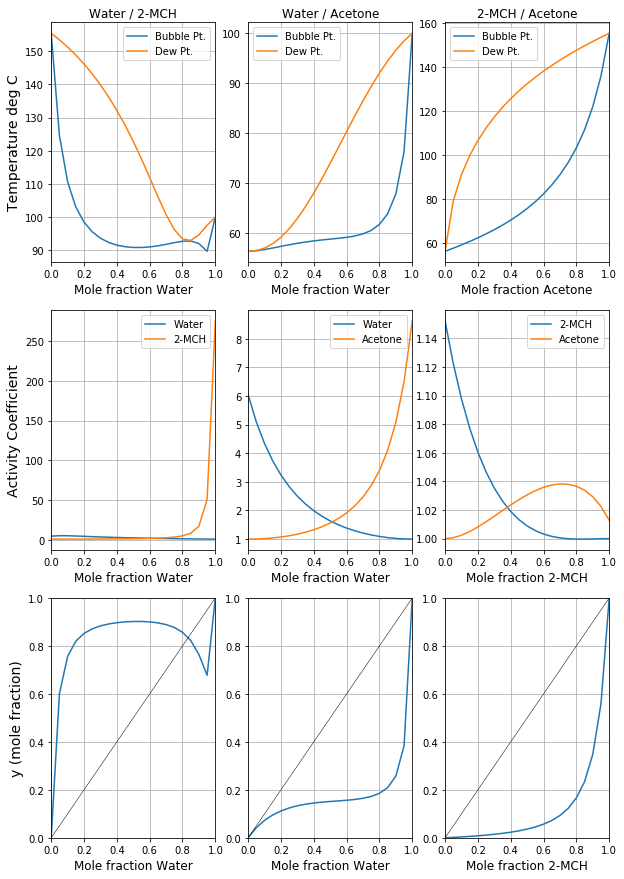

In [62]:
x = np.linspace(0,1,21).tolist()
    # Pair 1-2
for xFrac in x:
    Tbubble, = fsolve(lambda T: bubblePt([xFrac,1-xFrac,0],T,P), Tguess, xtol=1e-12)
    Tdew, = fsolve(lambda T: dewPt([xFrac,1-xFrac,0],T,P), Tguess, xtol=1e-12)
    TDew[0].append( Tdew )
    TBub[0].append( Tbubble )

    tau[0,1] = a12 +  b12/(Tbubble+273.15)
    tau[0,2] = a13 +  b13/(Tbubble+273.15)
    tau[1,0] = a21 +  b21/(Tbubble+273.15)
    tau[1,2] = a23 +  b23/(Tbubble+273.15)
    tau[2,0] = a31 +  b31/(Tbubble+273.15)
    tau[2,1] = a32 +  b32/(Tbubble+273.15)
    [gam1, gam2, gam3] = nrtl(alpha, tau, Tbubble, np.asarray([xFrac,1-xFrac,0]))


    y1 = xFrac*gam1*Psat[Components[0]](Tbubble)/P
    y[0].append(y1)

    gam1List[0].append( gam1 )
    gam2List[0].append( gam2 )

    # Pair 1-3
for xFrac in x:
    Tbubble, = fsolve(lambda T: bubblePt([xFrac,0,1-xFrac],T,P), Tguess, xtol=1e-12)
    Tdew, = fsolve(lambda T: dewPt([xFrac,0,1-xFrac],T,P), Tguess, xtol=1e-12)
    TDew[1].append( Tdew )
    TBub[1].append( Tbubble )

    tau[0,1] = a12 +  b12/(Tbubble+273.15)
    tau[0,2] = a13 +  b13/(Tbubble+273.15)
    tau[1,0] = a21 +  b21/(Tbubble+273.15)
    tau[1,2] = a23 +  b23/(Tbubble+273.15)
    tau[2,0] = a31 +  b31/(Tbubble+273.15)
    tau[2,1] = a32 +  b32/(Tbubble+273.15)
    [gam1, gam2, gam3] = nrtl(alpha, tau, Tbubble, np.asarray([xFrac,0,1-xFrac]))

    y1 = xFrac*gam1*Psat[Components[0]](Tbubble)/P
    y[1].append(y1)

    gam1List[1].append( gam1 )
    gam3List[0].append( gam3 )

    # Pair 2-3
for xFrac in x:
    Tbubble, = fsolve(lambda T: bubblePt([0,xFrac,1-xFrac],T,P), Tguess, xtol=1e-12)
    Tdew, = fsolve(lambda T: dewPt([0,xFrac,1-xFrac],T,P), Tguess, xtol=1e-12)
    TDew[2].append( Tdew )
    TBub[2].append( Tbubble )

    tau[0,1] = a12 +  b12/(Tbubble+273.15)
    tau[0,2] = a13 +  b13/(Tbubble+273.15)
    tau[1,0] = a21 +  b21/(Tbubble+273.15)
    tau[1,2] = a23 +  b23/(Tbubble+273.15)
    tau[2,0] = a31 +  b31/(Tbubble+273.15)
    tau[2,1] = a32 +  b32/(Tbubble+273.15)
    [gam1, gam2, gam3] = nrtl(alpha, tau, Tbubble, np.asarray([0,xFrac,1-xFrac]))

    y1 = xFrac*gam2*Psat[Components[1]](Tbubble)/P
    y[2].append(y1)

    gam2List[1].append( gam2 )
    gam3List[1].append( gam3 )



plt1.figure(figsize=(10,15))

# Plot T-xy
# =========
plt1.subplot(3,3,1)
plt1.plot(x,TBub[0],x,TDew[0])
plt1.xlabel('Mole fraction '+Components[0], fontsize=12)
plt1.ylabel('Temperature deg C', fontsize=14)
plt1.title( Components[0] + ' / ' + Components[1], fontsize=12 )
plt1.legend(['Bubble Pt.','Dew Pt.'], fontsize=10)
plt1.grid()
plt1.xlim(0,1)

plt1.subplot(3,3,2)
plt1.plot(x,TBub[1],x,TDew[1])
plt1.xlabel('Mole fraction '+ Components[0], fontsize=12)
#plt1.ylabel('Temperature deg C', fontsize=14)
plt1.title( Components[0] + ' / ' + Components[2], fontsize=12)
plt1.legend(['Bubble Pt.','Dew Pt.'], fontsize=10)
plt1.grid()
plt1.xlim(0,1)

plt1.subplot(3,3,3)
plt1.plot(x,TBub[2],x,TDew[2])
plt1.xlabel('Mole fraction '+ Components[2], fontsize=12)
#plt1.ylabel('Temperature deg C', fontsize=14)
plt1.title( Components[1] + ' / ' + Components[2], fontsize=12)
plt1.legend(['Bubble Pt.','Dew Pt.'], fontsize=10)
plt1.grid()
plt1.xlim(0,1)

# Plot Activity Coefficients (NRTL model)
# =======================================
plt1.subplot(3,3,4)
plt1.plot(x,gam1List[0],x,gam2List[0])
plt1.xlabel('Mole fraction '+Components[0], fontsize=12)
plt1.ylabel('Activity Coefficient', fontsize=14)
#plt1.title( Components[0] + ' / ' + Components[1], fontsize=12 )
plt1.legend([Components[0],Components[1]], fontsize=10)
plt1.grid()
plt1.xlim(0,1)

plt1.subplot(3,3,5)
plt1.plot(x,gam1List[1],x,gam3List[0])
plt1.xlabel('Mole fraction '+Components[0], fontsize=12)
plt1.legend([Components[0],Components[2]], fontsize=10)
plt1.grid()
plt1.xlim(0,1)

plt1.subplot(3,3,6)
plt1.plot(x,gam2List[1],x,gam3List[1])
plt1.xlabel('Mole fraction '+Components[1], fontsize=12)
plt1.legend([Components[1],Components[2]], fontsize=10)
plt1.grid()
plt1.xlim(0,1)

    # Plot y vs x
    # ============
plt1.subplot(3,3,7)
plt1.plot(x,y[0])
plt1.xlabel('Mole fraction '+Components[0], fontsize=12)
plt1.ylabel('y (mole fraction)', fontsize=14)
plt1.grid()
plt1.xlim(0,1)
plt1.ylim(0,1)
plt1.yticks(np.linspace(0,1.0,6))
plt1.plot([1, 0,], [1, 0], '-k',linewidth=.5)

plt1.subplot(3,3,8)
plt1.plot(x,y[1])
plt1.xlabel('Mole fraction '+Components[0], fontsize=12)
plt1.grid()
plt1.xlim(0,1)
plt1.ylim(0,1)
plt1.yticks(np.linspace(0,1.0,6))
plt1.plot([1, 0,], [1, 0], '-k',linewidth=.5)

plt1.subplot(3,3,9)
plt1.plot(x,y[2])
plt1.xlabel('Mole fraction '+Components[1], fontsize=12)
plt1.grid()
plt1.xlim(0,1)
plt1.ylim(0,1)
plt1.yticks(np.linspace(0,1.0,6))
plt1.plot([1, 0,], [1, 0], '-k',linewidth=.5)

In [0]:
def RCM( t,x ):
    x[0] = x[0]/(x[0] + x[1] + x[2])
    x[1] = x[1]/(x[0] + x[1] + x[2])
    x[2] = x[2]/(x[0] + x[1] + x[2])

    T, = fsolve(lambda T: bubblePt([x[0],x[1],x[2]],T,P), Tguess, xtol=1e-6)
    x = [x[0],x[1],x[2]]

    tau[0,1] = a12 +  b12/(T+273.15)
    tau[0,2] = a13 +  b13/(T+273.15)
    tau[1,0] = a21 +  b21/(T+273.15)
    tau[1,2] = a23 +  b23/(T+273.15)
    tau[2,0] = a31 +  b31/(T+273.15)
    tau[2,1] = a32 +  b32/(T+273.15)
    [gam1, gam2, gam3] = nrtl(alpha, tau, T, np.asarray(x))

    y1=x[0]*gam1*Psat[Components[0]](T)/P
    y2=x[1]*gam2*Psat[Components[1]](T)/P
    y3=x[2]*gam3*Psat[Components[2]](T)/P

    dxdt =  [   (x[0]-y1),
                (x[1]-y2),
                (x[2]-y3),
                 P - x[0]*gam1*Psat[Components[0]](T) - x[1]*gam2*Psat[Components[1]](T) - x[2]*gam3*Psat[Components[2]](T)]

    return dxdt

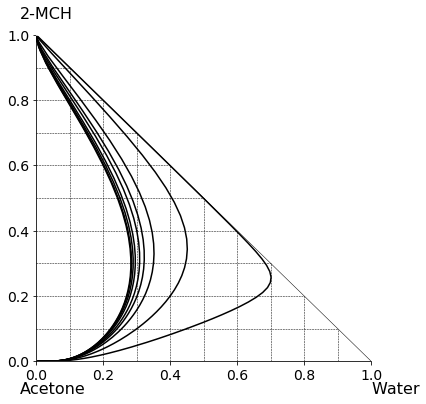

In [64]:
plt.figure(figsize=(6,6))
#plt.plot([.1, .2, .3, .95], [.1, .4, .6,.95], 'ro')

plt.axis([0, 1, 0, 1])
#mix = ['2-MCH','Acetone','Water']
#mix = ['IPA', 'Ethanol','Methanol']


cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(True)
cur_axes.axes.get_yaxis().set_visible(True)

cur_axes.spines['bottom'].set_color('k')
cur_axes.spines['top'].set_color('w') 
cur_axes.spines['right'].set_color('w')
cur_axes.spines['left'].set_color('k')
plt.plot([1, 0,], [0, 1], '-k',linewidth=.5)
#plt.plot([0, 0,], [0, 1], '-b',linewidth=1)
#plt.plot([0, 0,], [1, 0], '-r',linewidth=1)

#plt.xlabel('Ethanol liquid', fontsize=12)
#plt.ylabel('Activity Coefficient', fontsize=12)
#plt.title('Residue Curve Map', fontsize=16)

plt.text(1,-.1,Components[0],fontsize=16)
plt.text(-.05,1.05,Components[1],fontsize=16)
plt.text(-.05,-.1,Components[2],fontsize=16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

#plt.plot([0,  1.0],[0.0,  0.0],'k')
plt.plot([0, 0.9],[0.1, 0.1],'--k',linewidth=.5)
plt.plot([0, 0.8],[0.2, 0.2],'--k',linewidth=.5)
plt.plot([0, 0.7],[0.3, 0.3],'--k',linewidth=.5)
plt.plot([0, 0.6],[0.4, 0.4],'--k',linewidth=.5)
plt.plot([0, 0.5],[0.5, 0.5],'--k',linewidth=.5)
plt.plot([0, 0.4],[0.6, 0.6],'--k',linewidth=.5)
plt.plot([0, 0.3],[0.7, 0.7],'--k',linewidth=.5)
plt.plot([0, 0.2],[0.8, 0.8],'--k',linewidth=.5)
plt.plot([0, 0.1],[0.9, 0.9],'--k',linewidth=.5)
#   Plot Y gridlines
plt.plot([0.1, 0.1],[0.0, 0.9],'--k',linewidth=.5)
plt.plot([0.2, 0.2],[0.0, 0.8],'--k',linewidth=.5)
plt.plot([0.3, 0.3],[0.0, 0.7],'--k',linewidth=.5)
plt.plot([0.4, 0.4],[0.0, 0.6],'--k',linewidth=.5)
plt.plot([0.5, 0.5],[0.0, 0.5],'--k',linewidth=.5)
plt.plot([0.6, 0.6],[0.0, 0.4],'--k',linewidth=.5)
plt.plot([0.7, 0.7],[0.0, 0.3],'--k',linewidth=.5)
plt.plot([0.8, 0.8],[0.0, 0.2],'--k',linewidth=.5)
plt.plot([0.9, 0.9],[0.0, 0.1],'--k',linewidth=.5)

# Plot feed composition window
WaterFeedRange      = [0.1, 0.2]        # mass fraction
AcetoneFeedRange    = [0.65, 0.75]       # mass fraction
MCHFeedRange        = [0.1, 0.2]        # mass fraction
yOffset = 0.55
xOffset = 0.55
lw = 2.0

npts = 1
pts = [[0.05,0.9],[0.1,0.8],[0.15,0.7],[0.20,0.6],[0.25,0.5],[0.30,0.4],[0.35,0.3],[0.40,0.2],[0.45,0.1]]

for pt in pts:

    fwd = 1
    bwd = 1
    #plt.plot(pt[0],pt[1],'.b')
    Tbubble, = fsolve(lambda T: bubblePt([pt[0],pt[1],1-pt[0]-pt[1]],T,P), Tguess, xtol=1e-12)
    IC = np.transpose([pt[0], pt[1], 1-pt[0]-pt[1], Tbubble])

    # Using bdf method
    # ====================

    t = []
    x1= []
    x2 = []


    if fwd:
        x1f = []
        x2f = []
        x3f = []
        Tf = []
        x1f.append(IC[0])
        x2f.append(IC[1])

        r1 = ode(RCM).set_integrator('vode', method='bdf', with_jacobian=False)
        y0, t0 = IC, 0
        r1.set_initial_value(y0, t0)
        t1 = 50
        dt = .1
        while r1.successful() and r1.t < t1:
            r1.integrate(r1.t+dt)
            t.append(r1.t)
            x1f.append( np.real(r1.y.tolist()[0]) )
            x2f.append( np.real(r1.y.tolist()[1]) )
            x3f.append( np.real(r1.y.tolist()[2]) )
            Tf.append( np.real(r1.y.tolist()[3]) )

    if bwd:
        x1b = []
        x2b = []
        x3b = []
        Tb = [] 
        x1b.append(IC[0])
        x2b.append(IC[1])

        r2 = ode(RCM).set_integrator('vode', method='bdf', with_jacobian=False)
        y0, t0 = IC, 0
        t1 = 50
        r2.set_initial_value(y0, t1)
        
        dt = -.1
        while r2.successful() and r2.t > 0:
            r2.integrate(r2.t+dt)
            t.append(r2.t)
            x1b.append( np.real(r2.y.tolist()[0]) )
            x2b.append( np.real(r2.y.tolist()[1]) )
            x3b.append( np.real(r2.y.tolist()[2]) )
            Tb.append( np.real(r2.y.tolist()[3]) )
        
    plt.plot(x1f, x2f,'-k')
    plt.plot(x1b, x2b,'-k')

plt.show()